Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

In [137]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor


from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     GridSearchCV, RandomizedSearchCV)


from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from pylab import *

# 1. Загрузка и предобработка данных

In [138]:
#создадим функцию, раскрывающую датасеты, помогающую изучить данные

def load_df(path):
    df=[]
    df = pd.read_csv(path)
    print(df.info())
    print()
    print(df.head(15))
    print()
    print(df.describe())
    return df

# Данные об электродах

In [139]:
data_arc = load_df('/datasets/final_steel/data_arc.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

    key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  Реактивная мощность
0     1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059             0.687084
1     1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607             0.520285
2     1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363             0.498805
3     1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363             1.062669
4     1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755             0.414397
5     2  2019-05-03 11:34:14  2019-05-03 11:36:31  

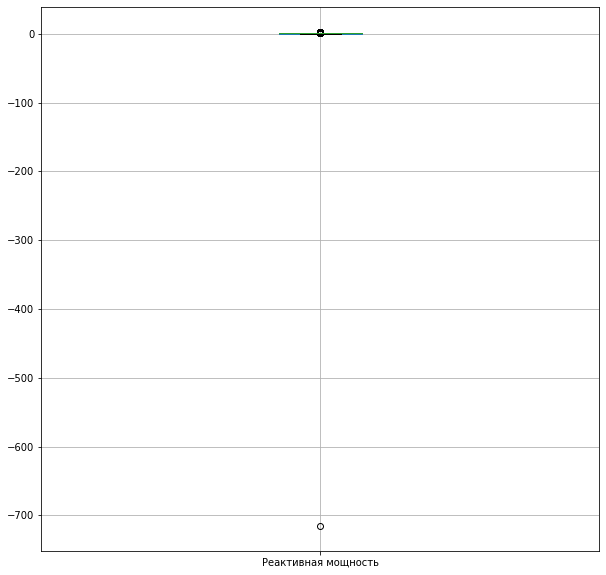

In [140]:
data_arc.boxplot('Реактивная мощность', figsize=(10,10))

In [141]:
arc_new = data_arc.loc[data_arc['Реактивная мощность']<0]

In [142]:
arc_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 9780 to 9780
Data columns (total 5 columns):
key                     1 non-null int64
Начало нагрева дугой    1 non-null object
Конец нагрева дугой     1 non-null object
Активная мощность       1 non-null float64
Реактивная мощность     1 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 48.0+ bytes


только одно значение ниже 0

http://electrokaprizam.net/content/35-chto-takoe-kva-kwt-kvar

In [143]:
#изменим названия столбцов
data_arc.columns = ['key','time_begin','time_end','activ_power','reactiv_power']

In [144]:
#изменим тип
data_arc[['time_begin', 'time_end']] = data_arc[['time_begin','time_end']].apply(pd.to_datetime)

In [145]:
data_arc.head(15)

,key,time_begin,time_end,activ_power,reactiv_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [146]:
# удалим выбросы
data_arc= data_arc.query('reactiv_power>0')

In [147]:
#создадим функцию, группирующую по партии и рангующую по дате. выберем последнюю дату и соответствующие мощности
def rank(df, i):
    df_g = df.groupby('key')
    def add(df_g):
        df_g['rank'] = df_g['time_end'].rank(pct=True)
        return df_g
    res = df_g.apply(add)
    result = res.query('rank == @i')
    return result

In [148]:
result_data_arc_1 = rank(data_arc, 1)

In [149]:
result_data_arc_1

,key,time_begin,time_end,activ_power,reactiv_power,rank
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,1.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,1.0
13,3,2019-05-03 12:31:14,2019-05-03 12:32:19,0.250280,0.155901,1.0
17,4,2019-05-03 12:53:12,2019-05-03 12:57:50,1.220955,0.754719,1.0
21,5,2019-05-03 13:32:44,2019-05-03 13:33:55,0.267457,0.181992,1.0
...,...,...,...,...,...,...
14854,3237,2019-08-31 23:01:32,2019-08-31 23:03:48,0.606049,0.419084,1.0
14857,3238,2019-08-31 23:38:38,2019-08-31 23:41:28,0.717559,0.520623,1.0
14865,3239,2019-09-01 02:13:38,2019-09-01 02:15:43,0.488352,0.317727,1.0
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994,1.0


In [150]:
# можем сделать дополнительные признаки по промежуточным стадиям каждой партии, но не будем
result_data_arc_2 = rank(data_arc, 0.2)

In [151]:
result_data_arc_2 

,key,time_begin,time_end,activ_power,reactiv_power,rank
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0.2
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,0.2
34,9,2019-05-03 15:33:42,2019-05-03 15:36:18,0.509361,0.410399,0.2
45,11,2019-05-03 16:49:14,2019-05-03 16:52:03,0.590658,0.431572,0.2
66,15,2019-05-03 20:53:55,2019-05-03 20:57:01,0.591491,0.464639,0.2
...,...,...,...,...,...,...
14762,3216,2019-08-31 06:28:11,2019-08-31 06:30:11,0.389077,0.371934,0.2
14793,3223,2019-08-31 12:53:21,2019-08-31 12:55:54,0.562438,0.379323,0.2
14850,3237,2019-08-31 22:41:18,2019-08-31 22:43:17,0.405685,0.320431,0.2
14866,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.411601,0.274390,0.2


In [152]:
#добавим признак полная мощность

result_data_arc_1['apparent_power'] = (result_data_arc_1['activ_power']**2+result_data_arc_1['reactiv_power']**2)**0.5

In [153]:
result_data_arc_1

,key,time_begin,time_end,activ_power,reactiv_power,rank,apparent_power
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,1.0,0.807239
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,1.0,0.975867
13,3,2019-05-03 12:31:14,2019-05-03 12:32:19,0.250280,0.155901,1.0,0.294865
17,4,2019-05-03 12:53:12,2019-05-03 12:57:50,1.220955,0.754719,1.0,1.435385
21,5,2019-05-03 13:32:44,2019-05-03 13:33:55,0.267457,0.181992,1.0,0.323503
...,...,...,...,...,...,...,...
14854,3237,2019-08-31 23:01:32,2019-08-31 23:03:48,0.606049,0.419084,1.0,0.736835
14857,3238,2019-08-31 23:38:38,2019-08-31 23:41:28,0.717559,0.520623,1.0,0.886532
14865,3239,2019-09-01 02:13:38,2019-09-01 02:15:43,0.488352,0.317727,1.0,0.582613
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994,1.0,0.689315


In [154]:
#сразу удалим ненужные столбцы c временем и рангом
result_data_arc_1 = result_data_arc_1.drop(['time_begin','time_end','rank'], axis=1)

In [155]:
result_data_arc_1

,key,activ_power,reactiv_power,apparent_power
4,1,0.692755,0.414397,0.807239
8,2,0.827743,0.516874,0.975867
13,3,0.250280,0.155901,0.294865
17,4,1.220955,0.754719,1.435385
21,5,0.267457,0.181992,0.323503
...,...,...,...,...
14854,3237,0.606049,0.419084,0.736835
14857,3238,0.717559,0.520623,0.886532
14865,3239,0.488352,0.317727,0.582613
14870,3240,0.548882,0.416994,0.689315


# Данные о подаче сыпучих материалов (объём)

In [156]:
data_bulk= load_df('/datasets/final_steel/data_bulk.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

    key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15
0     1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN     NaN      NaN      NaN    206.0      NaN    150.0    154.0
1     2     NaN     NaN     NaN    73.0     NaN     NaN  

In [157]:
#заменим NAN на 0
data_bulk=data_bulk.fillna(0)

In [158]:
data_bulk.head(30)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
5,6,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0
6,7,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0
7,8,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0
8,9,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0


In [159]:
#изменим названия столбцов
data_bulk.columns = ['key','bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6',\
                     'bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']

Диаграмма размаха сыпучих материалов


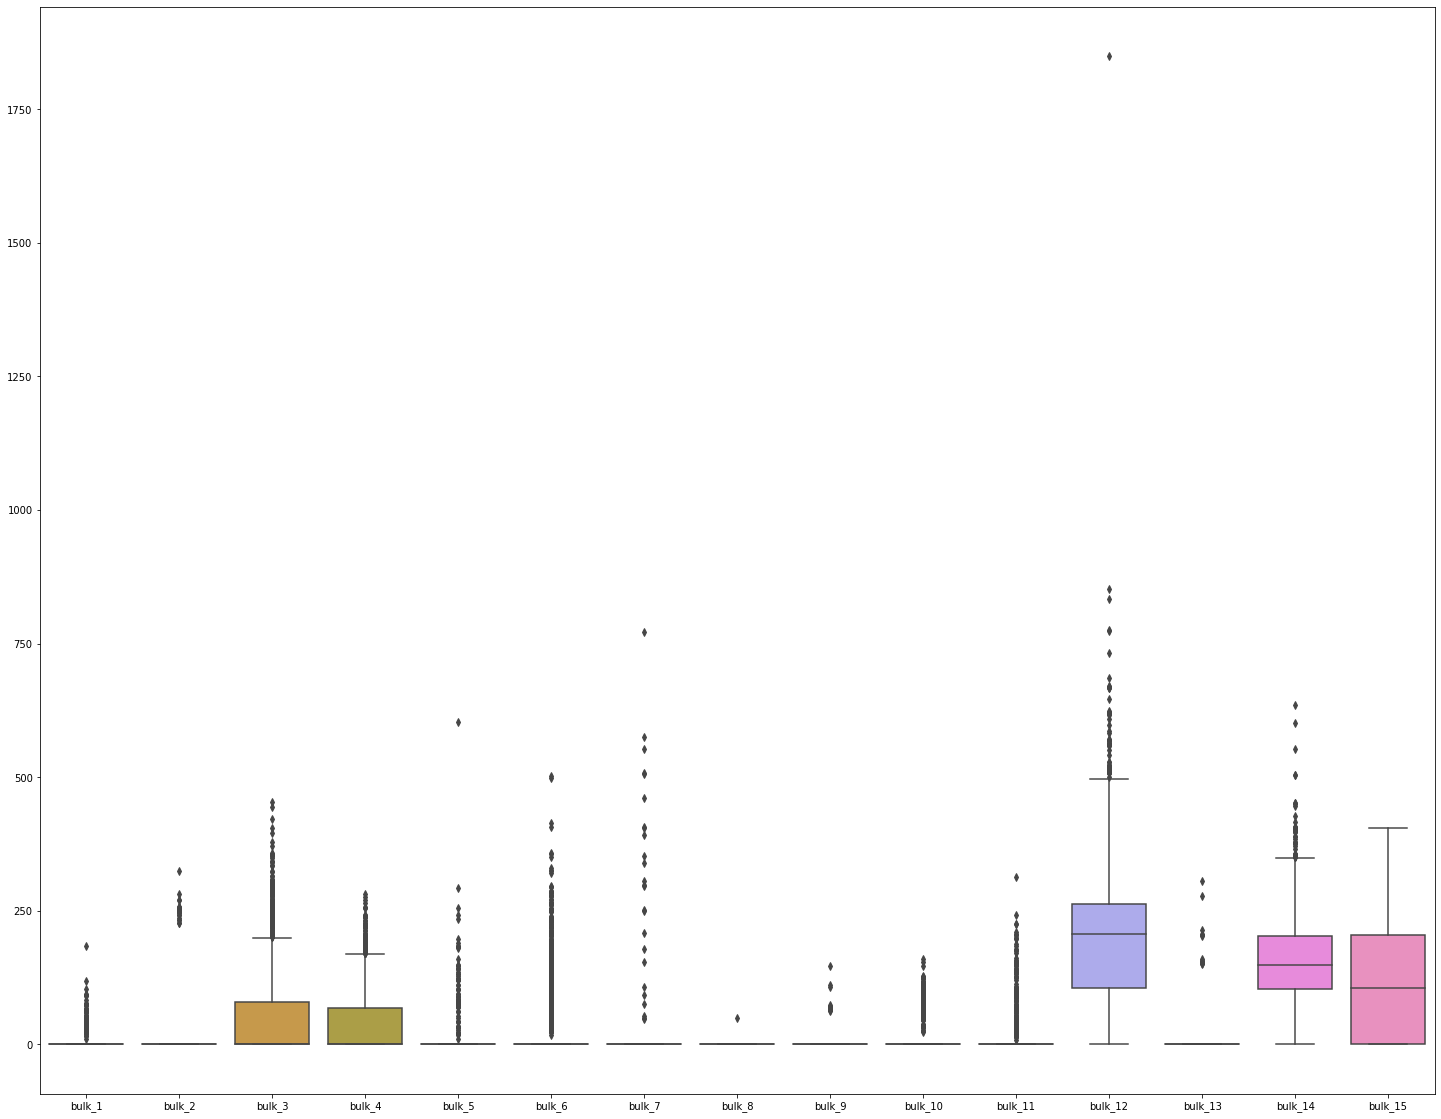

In [160]:
print("Диаграмма размаха сыпучих материалов")
plt.figure(figsize=(25,20)) 
sns.boxplot(data=data_bulk[['bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6',\
                     'bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']])

In [161]:
#уберем выбросы
data_bulk = data_bulk.query('bulk_3<250 & bulk_4<200 & bulk_12<500 & bulk_14<300')

In [162]:
data_bulk['bulk_sum'] = data_bulk['bulk_1']+data_bulk['bulk_2']+data_bulk['bulk_3']+data_bulk['bulk_4']+data_bulk['bulk_5']+\
                        data_bulk['bulk_6']+data_bulk['bulk_7']+data_bulk['bulk_8']+data_bulk['bulk_9']+data_bulk['bulk_10']+\
data_bulk['bulk_11']+data_bulk['bulk_12']+data_bulk['bulk_13']+data_bulk['bulk_14']+data_bulk['bulk_15']

# Данные о подаче сыпучих материалов (время)

In [163]:
data_bulk_time =load_df('/datasets/final_steel/data_bulk_time.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

    key               Bulk 1 Bulk 2               Bulk 3               Bulk 4 Bulk 5               Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14              Bulk 15
0     1                  NaN    NaN                  NaN  2019-05-03 11:21:30    NaN                  NaN    NaN    NaN    NaN

In [164]:
#изменим названия столбцов
data_bulk_time.columns = ['key','bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6',\
                          'bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']

In [165]:
#изменим тип
data_bulk_time[['bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7', \
                'bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14',\
                'bulk_15']] = data_bulk_time[['bulk_1','bulk_2','bulk_3','bulk_4',\
                'bulk_5','bulk_6','bulk_7','bulk_8','bulk_9','bulk_10','bulk_11',\
                'bulk_12','bulk_13','bulk_14','bulk_15']].apply(pd.to_datetime)

In [166]:
#заполним NAN пробелом
data_bulk_time = data_bulk_time.fillna('')

In [167]:
data_bulk_time.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,,,,2019-05-03 11:21:30,,,,,,,,2019-05-03 11:03:52,,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,,,,2019-05-03 11:46:38,,,,,,,,2019-05-03 11:40:20,,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,,,,2019-05-03 12:31:06,,,,,,,,2019-05-03 12:09:40,,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,,,,2019-05-03 12:48:43,,,,,,,,2019-05-03 12:41:24,,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,,,,2019-05-03 13:18:50,,,,,,,,2019-05-03 13:12:56,,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,,,,2019-05-03 13:59:24,,,,,,,,2019-05-03 13:53:27,,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,,,,2019-05-03 14:29:14,,,,,,,,2019-05-03 14:22:19,,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,,,,2019-05-03 15:04:05,,,,,,,,2019-05-03 14:55:46,,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,,,,2019-05-03 15:47:34,,,,,,,,2019-05-03 15:41:00,,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,,,,,,,,,,,,2019-05-03 16:18:52,,2019-05-03 16:18:52,2019-05-03 16:18:52


# Данные о продувке сплава газом

In [168]:
data_gas = load_df('/datasets/final_steel/data_gas.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

    key      Газ 1
0     1  29.749986
1     2  12.555561
2     3  28.554793
3     4  18.841219
4     5   5.413692
5     6  11.273392
6     7   9.836267
7     8  15.171553
8     9   8.216623
9    10   6.529891
10   11   3.639128
11   12  11.026259
12   13  11.443643
13   14   5.098945
14   15  11.085451
15   16   7.991257
16   17  15.175933
17   18  14.660061
18   19   6.556234
19   20  10.698530
20   21  14.615434
21   22  13.210861
22   23  14.515347
23   24  11.487776
24   25   9.060018
25   26   9.631086
26   27  10.404299
27   28  11.997002
28   29   5.955136
29   30  13.494307

               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.04

In [169]:
data_gas.columns = ['key', 'gas_1'] 

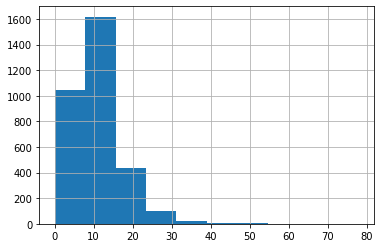

In [170]:
data_gas['gas_1'].hist()

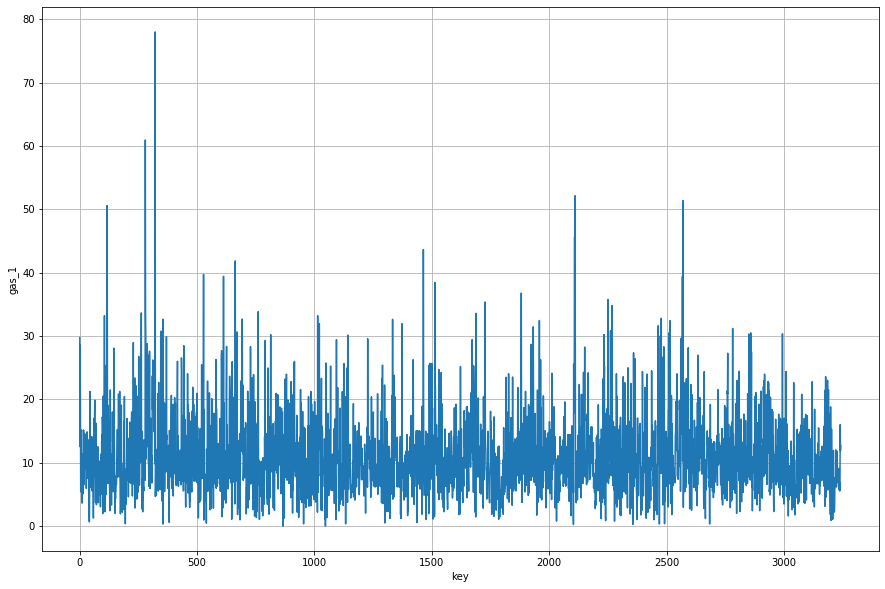

In [171]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(data_gas['key'], data_gas['gas_1'])

ax.set(xlabel='key', ylabel='gas_1')
      # title='About as simple as it gets, folks')
ax.grid()

#fig.savefig("test.png")
plt.show()

Диаграмма размаха по продувке сплава газом


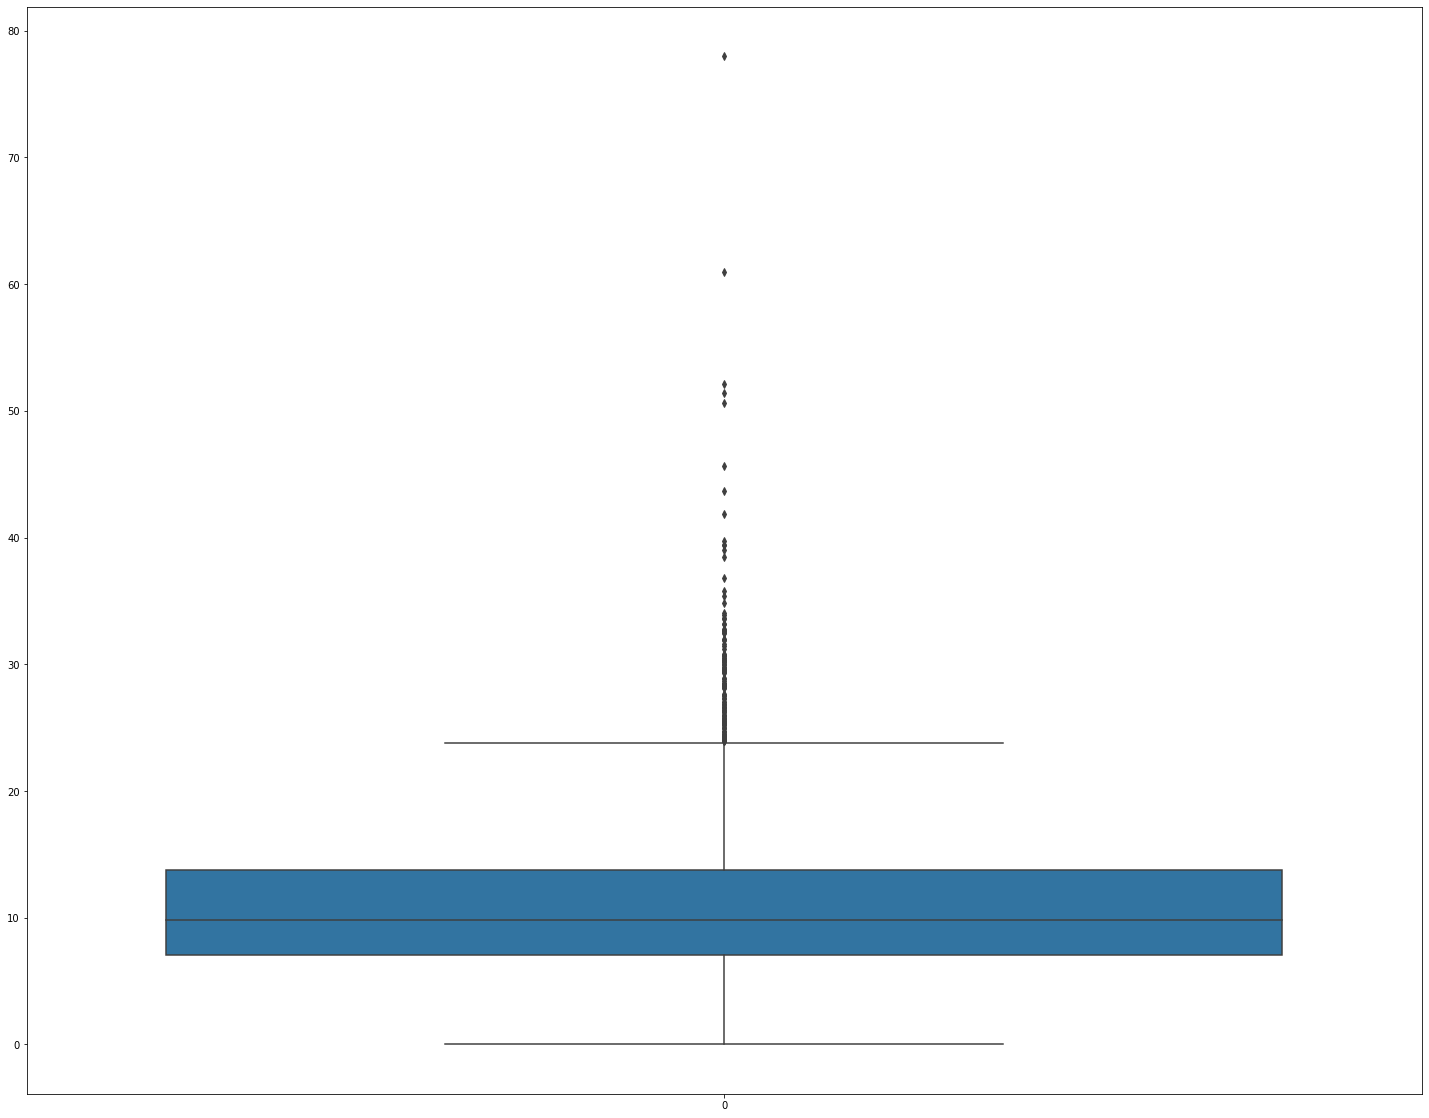

In [172]:
print("Диаграмма размаха по продувке сплава газом")
plt.figure(figsize=(25,20)) 
sns.boxplot(data=data_gas['gas_1'])

Наблюдаем выбросы в данных по продувке сплава газом

# Результаты измерения температуры

In [173]:
data_temp = load_df('/datasets/final_steel/data_temp.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

    key         Время замера  Температура
0     1  2019-05-03 11:16:18       1571.0
1     1  2019-05-03 11:25:53       1604.0
2     1  2019-05-03 11:29:11       1618.0
3     1  2019-05-03 11:30:01       1601.0
4     1  2019-05-03 11:30:39       1613.0
5     2  2019-05-03 11:37:27       1581.0
6     2  2019-05-03 11:38:00       1577.0
7     2  2019-05-03 11:49:38       1589.0
8     2  2019-05-03 11:55:50       1604.0
9     2  2019-05-03 11:58:24       1608.0
10    2  2019-05-03 11:59:12       1602.0
11    3  2019-05-03 12:13:17       1596.0
12    3  2019-05-03 12:18:36       1597.0
13    3  2019-05-03 12:25:06       1598.0
14    3  2019-05-03 12:30:48       1599.0
15    3  2019-05-03 12:34:57       1

отсутствуют данные в столбце температура. ничего не остается, как их дропнуть.

будем использовать только последнюю температуру

In [174]:
data_temp = data_temp.dropna()

In [175]:
#изменим названия колонок
data_temp.columns = ['key','time_end','temp']

In [176]:
#изменим тип
data_temp['time_end'] = data_temp['time_end'].apply(pd.to_datetime)
data_temp['temp'] = data_temp['temp'].astype(int)

In [177]:
data_temp

,key,time_end,temp
0,1,2019-05-03 11:16:18,1571
1,1,2019-05-03 11:25:53,1604
2,1,2019-05-03 11:29:11,1618
3,1,2019-05-03 11:30:01,1601
4,1,2019-05-03 11:30:39,1613
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569
15883,3238,2019-08-31 23:30:31,1584
15886,3239,2019-09-01 01:31:47,1598
15894,3240,2019-09-01 02:39:01,1617


In [178]:
#уберем все значения кроме последнего замера температуры. 
#значение последней измеренной температуры будет нашим целевым признаком

result_data_temp_1 = rank(data_temp, 1)

In [179]:
result_data_temp_1

,key,time_end,temp,rank
4,1,2019-05-03 11:30:39,1613,1.0
10,2,2019-05-03 11:59:12,1602,1.0
15,3,2019-05-03 12:34:57,1599,1.0
18,4,2019-05-03 12:59:25,1625,1.0
20,5,2019-05-03 13:36:01,1602,1.0
...,...,...,...,...
15878,3237,2019-08-31 22:44:04,1569,1.0
15883,3238,2019-08-31 23:30:31,1584,1.0
15886,3239,2019-09-01 01:31:47,1598,1.0
15894,3240,2019-09-01 02:39:01,1617,1.0


In [180]:
#сразу удалим ненужные столбцы c временем и температурой
result_data_temp_1 = result_data_temp_1.drop(['time_end', 'rank'], axis=1)

In [181]:
#создадим функцию, группирующую по партии и рангующую по дате. выберем только первое измерение температуры
def temp_first(df):
    df_g = df.groupby('key')
    def add(df_g):
        df_g['rank'] = df_g['time_end'].rank()
        return df_g
    res = df_g.apply(add)
    result = res.query('rank == 1')
    return result

In [182]:
#данные по первой температуре 
temp_1 = temp_first(data_temp)

In [183]:
temp_1

,key,time_end,temp,rank
0,1,2019-05-03 11:16:18,1571,1.0
5,2,2019-05-03 11:37:27,1581,1.0
11,3,2019-05-03 12:13:17,1596,1.0
16,4,2019-05-03 12:52:57,1601,1.0
19,5,2019-05-03 13:23:19,1576,1.0
...,...,...,...,...
15878,3237,2019-08-31 22:44:04,1569,1.0
15883,3238,2019-08-31 23:30:31,1584,1.0
15886,3239,2019-09-01 01:31:47,1598,1.0
15894,3240,2019-09-01 02:39:01,1617,1.0


In [187]:
#сразу удалим ненужные столбцы c временем и температурой
temp_1 = temp_1.drop(['time_end', 'rank'], axis=1)

# Данные о проволочных материалах (объём)

In [188]:
data_wire = load_df('/datasets/final_steel/data_wire.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

    key      Wire 1      Wire 2      Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9
0     1   60.059998         NaN         NaN     NaN     NaN     NaN     NaN     NaN     NaN
1     2   96.052315         NaN         NaN     NaN     NaN     NaN     NaN     NaN     NaN
2     3   91.160157         NaN         NaN     NaN     NaN     NaN     NaN     NaN     NaN
3     4   89.063515         NaN         NaN     NaN     NaN     NaN     NaN     NaN     NaN
4     5   89.238236    9.114560         NaN     NaN     NaN     NaN     

In [189]:
#изменим названия столбцов
data_wire.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7',\
                          'wire_8','wire_9']

In [190]:
#уберем NAN, заменив на 0
data_wire = data_wire.fillna(0)

Диаграмма размаха по проволочным материалам (объём)


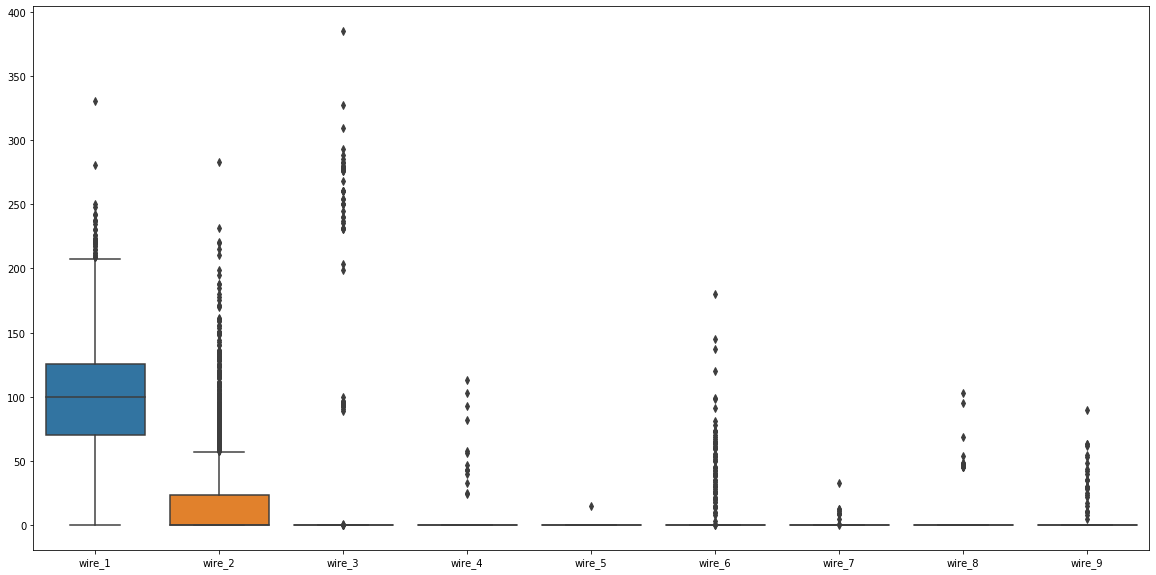

In [191]:
print("Диаграмма размаха по проволочным материалам (объём)")
plt.figure(figsize=(20,10)) 
sns.boxplot(data=data_wire[['wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7',\
                          'wire_8','wire_9']])

In [192]:
#уберем выбросы
data_wire = data_wire.query('wire_1<220 & wire_2<70')

In [193]:
#посчитаем суммарный объем проволоки

In [194]:
data_wire['wire_sum']=data_wire['wire_1']+data_wire['wire_2']+data_wire['wire_3']+data_wire['wire_4']+data_wire['wire_5']+\
                      data_wire['wire_6']+data_wire['wire_7']+data_wire['wire_8']+ data_wire['wire_9']

# Данные о проволочных материалах (время)

In [195]:
data_wire_time = load_df('/datasets/final_steel/data_wire_time.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

    key               Wire 1               Wire 2               Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
0     1  2019-05-03 11:11:41                  NaN                  NaN    NaN    NaN    NaN    NaN    NaN    NaN
1     2  2019-05-03 11:46:10                  NaN                  NaN    NaN    NaN    NaN    NaN    NaN    NaN
2     3  2019-05-03 12:13:47                  NaN                  NaN    NaN    NaN    NaN    NaN    NaN    NaN
3     4  2019-05-03 12:48:05                  NaN                  NaN    NaN    NaN    N

In [196]:
#изменим названия столбцов
data_wire_time.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7',\
                          'wire_8','wire_9']

In [197]:
#уберем NAN, заменив на пробел
data_wire_time = data_wire_time.fillna('')

In [198]:
#изменим тип
data_wire_time[['wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7',\
                          'wire_8','wire_9']] = data_wire_time[['wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7',\
                          'wire_8','wire_9']].apply(pd.to_datetime)

# Объединение итоговой таблицы

In [199]:
# из данных датасетов будем делать делать датафрейм с признаками
# result_data_arc_1, data_bulk, data_gas, data_wire, temp_1
#result_data_temp_1  - в данном датафрейме находится наш целевой признак

In [200]:
full = result_data_arc_1.merge(data_bulk, on='key').merge(data_gas, on='key').merge(data_wire, on='key').merge(result_data_temp_1, on='key').merge(temp_1, on='key')#merge(result_data_temp_1, on='key').merge(result_data_temp_2, on='key')#.merge(result_data_temp_3, on='key').merge(result_data_temp_4, on='key').merge(result_data_temp_5, on='key')

In [201]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2432
Data columns (total 33 columns):
key               2433 non-null int64
activ_power       2433 non-null float64
reactiv_power     2433 non-null float64
apparent_power    2433 non-null float64
bulk_1            2433 non-null float64
bulk_2            2433 non-null float64
bulk_3            2433 non-null float64
bulk_4            2433 non-null float64
bulk_5            2433 non-null float64
bulk_6            2433 non-null float64
bulk_7            2433 non-null float64
bulk_8            2433 non-null float64
bulk_9            2433 non-null float64
bulk_10           2433 non-null float64
bulk_11           2433 non-null float64
bulk_12           2433 non-null float64
bulk_13           2433 non-null float64
bulk_14           2433 non-null float64
bulk_15           2433 non-null float64
bulk_sum          2433 non-null float64
gas_1             2433 non-null float64
wire_1            2433 non-null float64
wire_2         

In [202]:
full = full.drop_duplicates(keep='first')

In [203]:
full

,key,activ_power,reactiv_power,apparent_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum,temp_x,temp_y
0,1,0.692755,0.414397,0.807239,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,1613,1571
1,2,0.827743,0.516874,0.975867,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,1602,1581
2,3,0.250280,0.155901,0.294865,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,1599,1596
3,4,1.220955,0.754719,1.435385,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,1625,1601
4,5,0.267457,0.181992,0.323503,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,1602,1576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,3237,0.606049,0.419084,0.736835,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0,5.543905,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959,1569,1569
2429,3238,0.717559,0.520623,0.886532,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0,6.745669,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799,1584,1584
2430,3239,0.488352,0.317727,0.582613,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0,16.023518,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761,1598,1598
2431,3240,0.548882,0.416994,0.689315,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0,11.863103,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.070400,1617,1617


Выбор признаков

In [204]:
corr=full.corr() #выделим признаки, которые влияют конечную температуру
print("Значения корреляции цены и факторов")
print( corr['temp_x']) 

Значения корреляции цены и факторов
key              -0.139860
activ_power       0.007202
reactiv_power    -0.013174
apparent_power   -0.000917
bulk_1           -0.015897
bulk_2            0.022789
bulk_3           -0.047278
bulk_4            0.105926
bulk_5           -0.010571
bulk_6           -0.118795
bulk_7           -0.018331
bulk_8           -0.016341
bulk_9           -0.035255
bulk_10           0.055314
bulk_11          -0.107891
bulk_12           0.100407
bulk_13          -0.000824
bulk_14           0.033457
bulk_15           0.108221
bulk_sum          0.079655
gas_1             0.035761
wire_1            0.207774
wire_2           -0.078648
wire_3            0.006654
wire_4           -0.084192
wire_5            0.036892
wire_6           -0.036054
wire_7            0.044737
wire_8           -0.034174
wire_9           -0.000210
wire_sum          0.122803
temp_x            1.000000
temp_y            0.523041
Name: temp_x, dtype: float64


# Вывод: 
Необходимые библиотеки добавлены, общая информация по датафрейму изучена. Была провена предобработка данных. Изменены типы данных, удалены выбросы. Данные объединины в один датафрейм для удобства дальнешней работы. Проведен анализ корреляции признаков. Все признаки минимально коррелируют с целевым признаком, кроме самой первой температуры, суммарного объема проволоки, объема первого вида проволоки.

# Подготовка выборок

https://pythonru.com/uroki/osnovy-pandas-3-vazhnye-metody-formatirovanija-dannyh

In [205]:
#создадим переменные для признаков и целевого признака:

features = full.drop(['key','temp_x'], axis=1) #'wire_3','wire_4','wire_5','wire_6','wire_7',\
                          #'wire_8','wire_9','bulk_1','bulk_3','bulk_4','bulk_6',\
                          #'bulk_10','bulk_11','bulk_12','bulk_14','bulk_15'
target= full['temp_x']

In [206]:
# разделим выборки, на тестовую и обучающую выборку признаков и целев признака
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [207]:
# #Произведем масштабирование 

# numeric = features.columns
# numeric

Index(['activ_power', 'reactiv_power', 'apparent_power', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'bulk_sum', 'gas_1', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'wire_sum', 'temp_y'], dtype='object')

In [208]:
# scaler = StandardScaler()
# scaler.fit(features_train[numeric])
# features_train[numeric] = scaler.transform(features_train[numeric])
# features_test[numeric] = scaler.transform(features_test[numeric])

Без масштабирования значение МАЕ меньше, поэтому было решено в данном проекте масштабирование не использовать.

# Обучение моделей и подбор гиперпараметров

In [209]:
#обучим модель линейной регрессии

model_LR = LinearRegression().fit(features_train,target_train)
predict_LR = model_LR.predict(features_train)
mae_LR = mean_absolute_error(target_train, predict_LR)
mae_LR

9.51563010331799

In [211]:
#подберем гиперпараметры для модели Catboost

model = CatBoostRegressor()
parameters = {'depth'         : [3, 5, 8],
                  'learning_rate' : [0.03,  0.1]
                  #,'iterations'    : [30, 100]
                 }
grid = GridSearchCV(estimator=model, scoring= 'neg_mean_absolute_error', param_grid = parameters, cv = 2)
gs_results_CB = grid.fit(features_train, target_train)    

print("BEST PARAMETERS: " + str(gs_results_CB.best_params_))

0:	learn: 14.7006972	total: 937us	remaining: 937ms
1:	learn: 14.6060888	total: 2.53ms	remaining: 1.26s
2:	learn: 14.5024509	total: 3.81ms	remaining: 1.27s
3:	learn: 14.4055849	total: 4.73ms	remaining: 1.18s
4:	learn: 14.3178006	total: 5.63ms	remaining: 1.12s
5:	learn: 14.2255952	total: 6.97ms	remaining: 1.15s
6:	learn: 14.1430158	total: 7.92ms	remaining: 1.12s
7:	learn: 14.0544926	total: 8.85ms	remaining: 1.1s
8:	learn: 13.9694446	total: 9.92ms	remaining: 1.09s
9:	learn: 13.8972548	total: 11.3ms	remaining: 1.12s
10:	learn: 13.8265174	total: 12.1ms	remaining: 1.09s
11:	learn: 13.7579774	total: 13ms	remaining: 1.07s
12:	learn: 13.6885932	total: 15ms	remaining: 1.14s
13:	learn: 13.6133885	total: 16.1ms	remaining: 1.14s
14:	learn: 13.5519911	total: 17.7ms	remaining: 1.16s
15:	learn: 13.4861897	total: 18.6ms	remaining: 1.14s
16:	learn: 13.4165570	total: 19.9ms	remaining: 1.15s
17:	learn: 13.3522947	total: 21ms	remaining: 1.15s
18:	learn: 13.3004599	total: 22.2ms	remaining: 1.14s
19:	learn: 

In [226]:
# обучим модель на лучших гиперпараметрах

model_CB = CatBoostRegressor(depth= 8, learning_rate= 0.03)#, depth=10, learning_rate=0.1, l2_leaf_reg=1)
model_CB.fit(features_train, target_train,  verbose=False)
predict_CB = model_CB.predict(features_train)
mae_CB = mean_absolute_error(target_train, predict_CB)
mae_CB

4.042862790860131

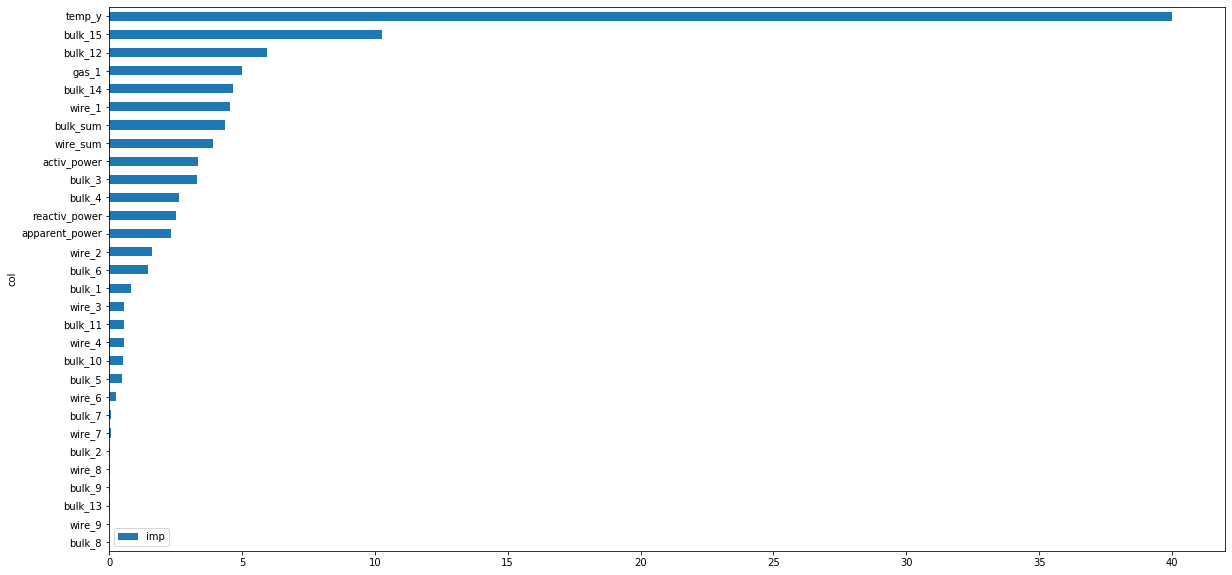

In [227]:
#построим график Feature Importance
feature_imp = pd.DataFrame({'imp': model_CB.feature_importances_, 'col': features.columns})
feature_imp = feature_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = feature_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')   

In [214]:
#подберем гиперпараметры для модели LGBM

hyper_space = {'n_estimators': [300, 600, 1000, 1500, 2500],
               'max_depth':  [4, 9, 15],
               'learning_rate': [0.1, 0.3]}
               #'num_leaves': [15,  63, 127]
               #'subsample': [0.6, 0.7, 0.8, 1.0],
               #'colsample_bytree': [0.6, 0.7, 0.8, 1.0]}

est = LGBMRegressor(boosting_type='gbdt', random_state=12345)

gs = GridSearchCV(est, hyper_space, scoring='neg_mean_absolute_error', cv=2, verbose=1)
gs_results = gs.fit(features_train, target_train)
print("BEST PARAMETERS: " + str(gs_results.best_params_))

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.6min finished


BEST PARAMETERS: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}


In [228]:
# обучим модель на лучших гиперпараметрах

model_LGBM = LGBMRegressor( depth = 4, learning_rate = 0.1, n_estimators = 300)
model_LGBM.fit(features_train, target_train)
predict_LGBM = model_LGBM.predict(features_train)
mae_LGBM = mean_absolute_error(target_train, predict_LGBM)
mae_LGBM

#https://www.kaggle.com/jens0306/easy-prediction-using-lightgbm-model

2.005471678899581

In [216]:
#найдем лучшие гиперпараметры для модели случайного леса при помощи grid search

model_RF = RandomForestRegressor()

grid_RF = {'max_depth': [10, 40,100,300],
           'n_estimators': [100, 200, 300, 500]}


rf_random = RandomizedSearchCV(estimator = model_RF, param_distributions = grid_RF, scoring='neg_mean_absolute_error', cv = 3)

#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [217]:
RF_random_results = rf_random.fit(features_train, target_train)
print("BEST PARAMETERS: " + str(RF_random_results.best_params_))

BEST PARAMETERS: {'n_estimators': 500, 'max_depth': 100}


In [229]:
#обучим модель случайного леса с лучшими гиперпараметрами

model_RF = RandomForestRegressor(n_estimators= 500, max_depth= 100)
model_RF.fit(features_train,target_train)
predict_RF=model_RF.predict(features_train)
mae_RF = mean_absolute_error(target_train, predict_RF)
mae_RF

3.340005871990607

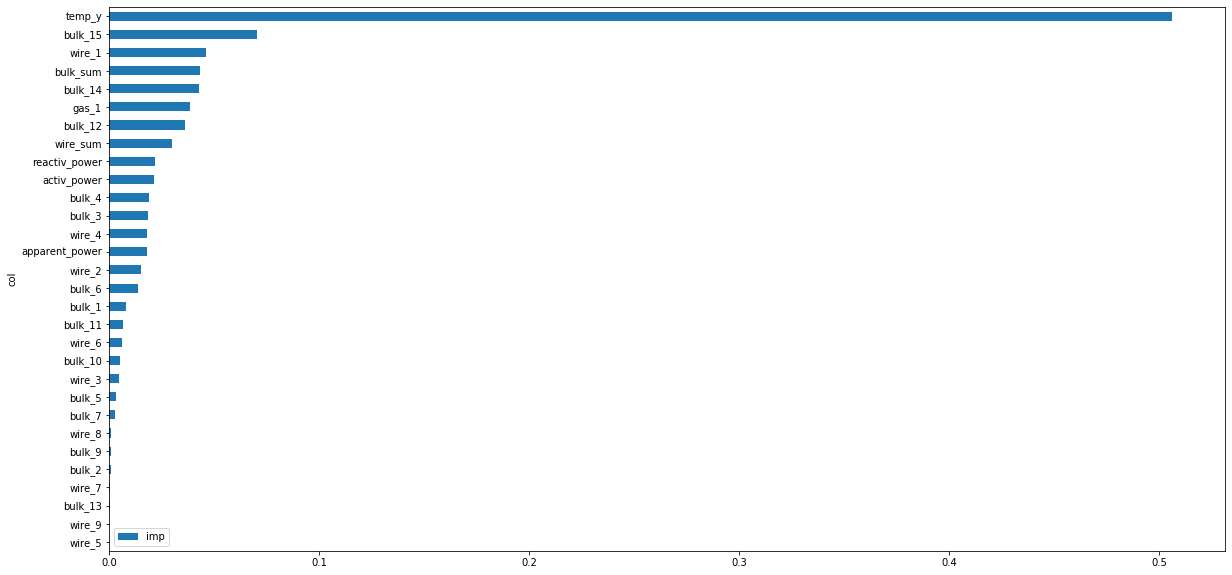

In [235]:
#Feature Importance для случайного леса
feature_imp = pd.DataFrame({'imp': model_RF.feature_importances_, 'col': features.columns})
feature_imp = feature_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = feature_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('rf_feature_importance.png')  

In [219]:
#обучим модель xgboost с лучшими гиперпараметрами

from xgboost import XGBRegressor 

model_XGB = XGBRegressor()

grid_XGB = {'max_depth': [1, 30, 50, 150],
           'n_estimators': [50, 300, 500, 1000, 1500]}

#base_score=0.5, booster='gbtree', colsample_bylevel=1,
 #      colsample_bytree=1, gamma=0, importance_type='gain',
  #     learning_rate=0.1, max_delta_step=0, max_depth=3,
   #    min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
    #   nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
     #  reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
      # subsample=1)
    
XGB_random = RandomizedSearchCV(estimator = model_XGB, param_distributions = grid_XGB, scoring='neg_mean_absolute_error', cv = 3, verbose=0, n_jobs = -1)   
XGB_random_results = XGB_random.fit(features_train, target_train)
print("BEST PARAMETERS: " + str(XGB_random_results.best_params_))

[12:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [236]:
model_XGB = XGBRegressor(n_estimators= 500, max_depth= 150)
model_XGB.fit(features_train,target_train)
predict_XGB=model_XGB.predict(features_train)
mae_XGB = mean_absolute_error(target_train, predict_XGB)
mae_XGB

[12:51:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.0004150247265854375

# Проверка моделей на тестовой выборке

In [230]:
%%time

predict_LR = model_LR.predict(features_test)
mae_LR = mean_absolute_error(target_test, predict_LR)
mae_LR

CPU times: user 5.37 ms, sys: 16.9 ms, total: 22.3 ms
Wall time: 5.54 ms


9.246985233391884

In [231]:
%%time

predict_CB = model_CB.predict(features_test)
mae_CB = mean_absolute_error(target_test, predict_CB)
mae_CB

CPU times: user 15.6 ms, sys: 4.59 ms, total: 20.1 ms
Wall time: 13.3 ms


8.373413091354486

In [232]:
%%time

predict_LGBM = model_LGBM.predict(features_test)
mae_LGBM = mean_absolute_error(target_test, predict_LGBM)
mae_LGBM

CPU times: user 49.1 ms, sys: 117 µs, total: 49.3 ms
Wall time: 46.8 ms


9.01083456204969

In [233]:
%%time

predict_RF = model_RF.predict(features_test)
mae_RF = mean_absolute_error(target_test, predict_RF)
mae_RF

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 123 ms


8.321076712328768

In [237]:
%%time

predict_XGB = model_XGB.predict(features_test)
mae_XGB = mean_absolute_error(target_test, predict_XGB)
mae_XGB

CPU times: user 60.2 ms, sys: 3.94 ms, total: 64.1 ms
Wall time: 62.5 ms


8.762504682148972

# Вывод:

Необходимые библиотеки добавлены, общая информация по датафрейму изучена. 

Была провена предобработка данных. Изменены типы данных, удалены выбросы. 

Данные объединины в один датафрейм для удобства дальнешней работы. 

Без масштабирования значение МАЕ меньше, поэтому было решено в данном проекте масштабирование не использовать. 

Были добавлены самостоятельно следующие признаки: суммарные данные по проволоке и сыпучим материалам, первый замер температуры.  
Проведен анализ корреляции признаков. 

Все признаки минимально коррелируют с целевым признаком, 
кроме самой первой температуры, суммарного объема проволоки, объема первого вида проволоки. 

Модель Catboost с гиперпараметрами depth= 8, learning_rate= 0.03 показала наилучшие результаты.